## Figure 1 code
Elena Savidge
<br>
30 Oct 2024

In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import netCDF4
import pyproj
import numpy as np
import cmocean
from pyproj import Proj, transform, CRS
import cartopy.crs as ccrs
from shapely.geometry import Point, Polygon
from glob import glob
from pyhdf.SD import SD, SDC
import scipy
from scipy import ndimage
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from shapely.geometry import box
from pyproj import Transformer

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# need this line for pyproj to work on my machine
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/sealenv/share/proj') 

In [4]:
# read in data (download from https://nsidc.org/data/nsidc-0754/versions/1)
veldata = netCDF4.Dataset('../antarctic_ice_vel_phase_map_v01.nc')

## Read in grounding line

In [5]:
# Define your points and create a bounding box polygon
p1 = Point(-110, -70.5)
p2 = Point(-111.7, -75.4)
p3 = Point(-98.0, -75.4)
p4 = Point(-99.5, -70.5)

# Define the bounding box CRS
crs = "EPSG:4326"  # Adjust this based on your data's CRS
bb_polygon = Polygon([p1, p2, p3, p4])
map_extent = gpd.GeoDataFrame(geometry=[bb_polygon], crs=crs)

# Read in the coastline with a defined CRS
coastline = '../add_coastline_high_res_line_v7_4.shp'  #version 7.4 is updated
# can download at: https://data.bas.ac.uk/items/e46be5bc-ef8e-4fd5-967b-92863fbe2835/
shelf = gpd.read_file(coastline)

# Make sure both GeoDataFrames have the same CRS
shelf = shelf.to_crs(crs)

# Check the intersection
intersection = map_extent.intersects(shelf.unary_union)
print("Intersection:", intersection)

# Clip with the same CRS
shelf_clip = gpd.clip(shelf, map_extent)
shelf_clip = shelf_clip[~shelf_clip.is_empty]
# land = shelf_clip.loc[shelf_clip['surface'] == 'land']
# ice = shelf_clip.loc[shelf_clip['surface'] == 'ice shelf']
GL = shelf_clip.loc[shelf_clip['surface'] == 'grounding line']

# Print lengths to verify
print("Length of original shelf:", len(shelf))
print("Length of clipped shelf:", len(shelf_clip))
# print("Length of land:", len(land))
# print("Length of ice:", len(ice))
print("Length of GL:", len(GL))

Intersection: 0    True
dtype: bool
Length of original shelf: 30663
Length of clipped shelf: 212
Length of GL: 43


## Panel (a)

In [6]:
# Extract variables from veldata
lonsb = veldata.variables['x'][:]
latsb = veldata.variables['y'][:]
velx = veldata.variables['VX'][:]
vely = veldata.variables['VY'][:]

# Subset the data (if necessary)
subset_slice = slice(6000, 8000), slice(2000, 3500)  #subset
velx_subset = velx[subset_slice]
vely_subset = vely[subset_slice]

# Create meshgrid for plotting
x_b, y_b = np.meshgrid(lonsb, latsb)

# Optional: Subset the meshgrid to match the velocity data subset
# This step assumes lonsb and latsb are 1D arrays covering the full data range
x_b_subset = x_b[subset_slice]
y_b_subset = y_b[subset_slice]

In [7]:
# Modify cbar to skip lighter colors so that they appear better on map
import matplotlib.colors as mcolors
original_cmap = cmocean.cm.dense

# Start the new colormap from 35% into the original colormap
start = 0.35
stop = 1.0

# Create a new colormap based on the original but starting from 'start'
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    'truncated_' + str(original_cmap.name),
    original_cmap(np.linspace(start, stop, 256))
)

(-1690000.0, -1520000.0)

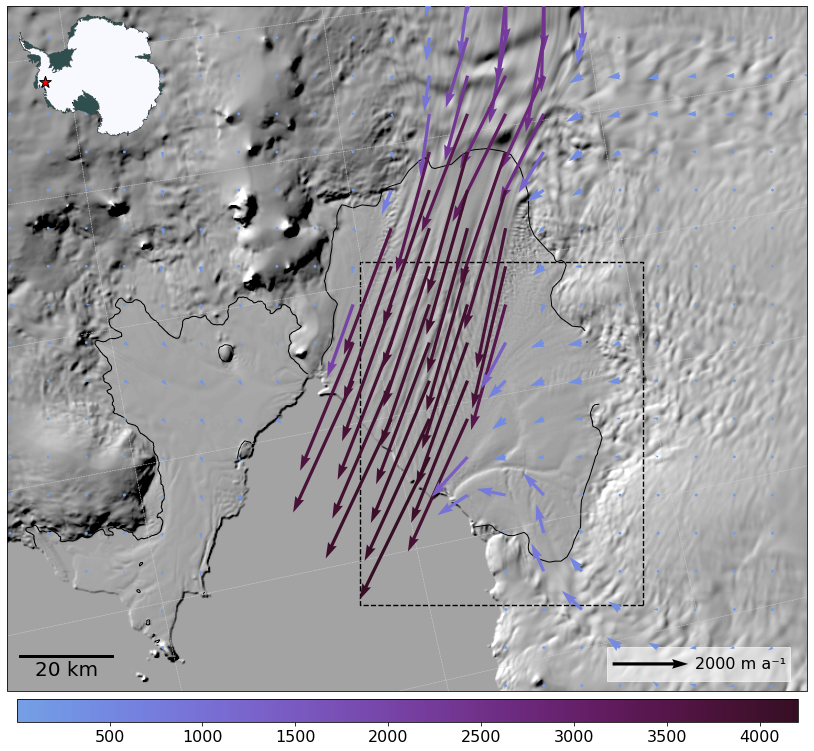

In [8]:
# 1. Transform grounding line data to the South Polar Stereographic projection (EPSG:3031)
GL_crs_transformed = GL.to_crs(epsg=3031)

# 2. Compute the magnitude of the velocity vectors (sqrt of velx^2 + vely^2)
magnitude = np.sqrt(velx_subset**2 + vely_subset**2)

# 3. Load the TIFF image data
file_path = '../94602e53-1130-40a7-9556-11acc2eeba3e.tiff'  # Path to the .tiff file
#file_path= '../ea2582d4-3b33-402f-b6d8-32ba4bbd6c46.tiff'
with rasterio.open(file_path) as src:
    image_data = src.read(1)  # Load the first band of the TIFF image
    bounds = src.bounds  # Get the spatial bounds of the image
    tiff_crs = src.crs  # Get the coordinate reference system (CRS) of the image

# 4. Set up the Cartopy projection for South Polar Stereographic (EPSG:3031)
projection = ccrs.SouthPolarStereo(true_scale_latitude=-71, central_longitude=-101)

# 5. Create the plot with the South Polar Stereographic projection
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': projection})

# 6. Display the TIFF image as the background in the plot
img_extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]  # Define the extent of the image
ax.imshow(image_data, origin='upper', extent=img_extent, transform=projection, cmap='gray')

# 7. Add gridlines to the plot (optional styling can be adjusted)
gl = ax.gridlines(draw_labels=False, color='lightgrey', linestyle='--', linewidth=0.5)

# 8. Plot velocity vectors using quiver (adjust the 'skip' parameter to control arrow density)
skip = 18  # Adjusts the density of the arrows
arrow_width= 0.004
quiver = ax.quiver(x_b_subset[::skip, ::skip], y_b_subset[::skip, ::skip],
                   velx_subset[::skip, ::skip], vely_subset[::skip, ::skip],
                   magnitude[::skip, ::skip],  # Color the arrows by velocity magnitude
                   transform=projection, cmap=new_cmap, scale=None, width=arrow_width, zorder=3)

# 9. Add a semi-transparent background patch for the quiverkey
bgd_rectangle = mpatches.Rectangle((0.75, 0.015), 0.228, 0.05, transform=ax.transAxes, 
                                   color='white', alpha=0.6, zorder=2, clip_on=False)
ax.add_patch(bgd_rectangle)

# 10. Add a quiverkey for velocity scale
# ax.quiverkey(quiver, 0.851, 0.04, 2000, '2000 m/yr', labelpos='E',
#              coordinates='axes', fontproperties={'size': 16})
ax.quiverkey(quiver, 0.851, 0.04, 2000, '2000 m a⁻¹', labelpos='E',
             coordinates='axes', fontproperties={'size': 16})

# 11. Add the grounding line to the plot
ax.add_geometries(GL_crs_transformed['geometry'], crs=projection, facecolor='None', edgecolor='k', linewidth=1)

# 12. Set the plot boundaries to match the TIFF's extent
ax.set_extent([bounds.left, bounds.right, bounds.bottom, bounds.top], crs=projection)

# 13. Add a colorbar for the velocity field
cb = plt.colorbar(quiver, ax=ax, orientation='horizontal', pad=0.01, aspect=35, shrink=0.70)
cb.ax.tick_params(labelsize=16)

# 14. Add a scalebar for distance representation (20 km)
fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(ax.transData,
                           20000, '20 km', 'lower left', 
                           pad=0.5, color='k', frameon=False, size_vertical=350,
                           fill_bar=True, sep=3.5, fontproperties=fontprops)
ax.add_artist(scalebar)

# 15. Add an inset map showing the MODIS MOA 2014 coastline and grounding line
# can download at: https://nsidc.org/data/nsidc-0730/versions/1
moa_2014_coastline = gpd.read_file('../moa_2004_coastline_v02.0.shp')
moa_2014_groundingline = gpd.read_file('../moa_2004_groundingline_v02.0.shp', crs=3031)

# 16. Configure inset axes for location overview
axIns = ax.inset_axes([0.005, 0.8, 0.2, 0.2])  # Create the inset map at the top left
axIns.set_aspect('equal')

# Plot coastline and grounding line on the map
moa_2014_coastline.plot(ax=axIns, color='darkslategray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)

# Make the background of the inset transparent
axIns.patch.set_alpha(0)

# Hide inset axes borders and ticks
for spine in axIns.spines.values():
    spine.set_visible(False)
axIns.xaxis.set_visible(False)
axIns.yaxis.set_visible(False)

# Mark the approximate position of Pine Island Glacier with a red star in the inset
axIns.scatter(0.21, 0.45, marker='*', s=150, color='red', edgecolor='black', transform=axIns.transAxes)

# 17. Draw a bounding box around the region of interest
bbox = box(-1615000, -352574, -1555000, -279811)
ax.add_geometries([bbox], crs=projection, facecolor='none', edgecolor='k', linewidth=1.4, linestyle='--')

# 18. Set x-axis limits for the plot
#plt.xlim([-1690000, -1520000])
#plt.ylim([-400000, -180000])  # adjust as needed

# 19. Save the final plot as a PNG file (optional)
#plt.savefig('pigvelocity_3feb.png', format='png', dpi=400)

# 20. Display the plot
#plt.show()

## Review process edits: Fig. 1 zoom out

(-400000.0, -180000.0)

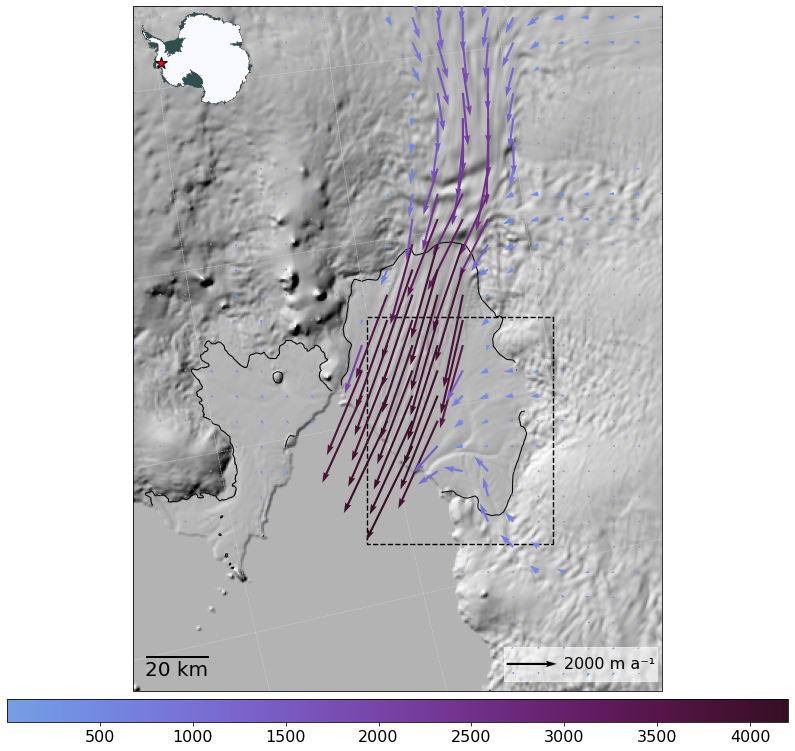

In [9]:
# 1. Transform grounding line data to the South Polar Stereographic projection (EPSG:3031)
GL_crs_transformed = GL.to_crs(epsg=3031)

# 2. Compute the magnitude of the velocity vectors (sqrt of velx^2 + vely^2)
magnitude = np.sqrt(velx_subset**2 + vely_subset**2)

# 3. Load the TIFF image data
#file_path = '../94602e53-1130-40a7-9556-11acc2eeba3e.tiff'  # Path to the .tiff file
file_path= '../47cb1b26-a192-4820-8f0f-8f1c50a9a020.tiff'
with rasterio.open(file_path) as src:
    image_data = src.read(1)  # Load the first band of the TIFF image
    bounds = src.bounds  # Get the spatial bounds of the image
    tiff_crs = src.crs  # Get the coordinate reference system (CRS) of the image

# 4. Set up the Cartopy projection for South Polar Stereographic (EPSG:3031)
projection = ccrs.SouthPolarStereo(true_scale_latitude=-71, central_longitude=-101)

# 5. Create the plot with the South Polar Stereographic projection
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': projection})

# 6. Display the TIFF image as the background in the plot
img_extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]  # Define the extent of the image
ax.imshow(image_data, origin='upper', extent=img_extent, transform=projection, cmap='gray')

# 7. Add gridlines to the plot (optional styling can be adjusted)
#gl = ax.gridlines(draw_labels=False, color='lightgrey', linestyle='--', linewidth=0.5)
#gl = ax.gridlines(draw_labels=True, xlocs=[-110, -108, -106, -104, -102, -100], ylocs=[-75, -74, -73, -72, -71],
#                  color='grey', linestyle='--')
#gl = ax.gridlines(draw_labels=True, xlocs=xlocs, ylocs=ylocs, color='grey', linestyle='--', linewidth=1, transform=projection)
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=[-102, -101, -100, -99], ylocs=[-75.5, -75, -74, -73, -72], color='k', linestyle=':')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, ylocs = [-75.5,-75,-74.5],
                 color='lightgrey', linestyle='--', linewidth=0.5)


# 8. Plot velocity vectors using quiver (adjust the 'skip' parameter to control arrow density)
skip = 18  # Adjusts the density of the arrows
arrow_width= 0.004
quiver = ax.quiver(x_b_subset[::skip, ::skip], y_b_subset[::skip, ::skip],
                   velx_subset[::skip, ::skip], vely_subset[::skip, ::skip],
                   magnitude[::skip, ::skip],  # Color the arrows by velocity magnitude
                   transform=projection, cmap=new_cmap, scale=None, width=arrow_width, zorder=3)

# Optionally, overlay velocity magnitude using pcolormesh
#data2 = ax.pcolormesh(x_b_subset, y_b_subset, magnitude, transform=projection, cmap=new_cmap, zorder=1, alpha=0.3)

# 9. Add a semi-transparent background patch for the quiverkey
bgd_rectangle = mpatches.Rectangle((0.70, 0.015), 0.29, 0.05, transform=ax.transAxes, 
                                   color='white', alpha=0.6, zorder=2, clip_on=False)
ax.add_patch(bgd_rectangle)

# 10. Add a quiverkey for velocity scale
# ax.quiverkey(quiver, 0.851, 0.04, 2000, '2000 m/yr', labelpos='E',
#              coordinates='axes', fontproperties={'size': 16})
ax.quiverkey(quiver, 0.80, 0.04, 2000, '2000 m a⁻¹', labelpos='E',
             coordinates='axes', fontproperties={'size': 16})

# 11. Add the grounding line to the plot
ax.add_geometries(GL_crs_transformed['geometry'], crs=projection, facecolor='None', edgecolor='k', linewidth=1)

# 12. Set the plot boundaries to match the TIFF's extent
ax.set_extent([bounds.left, bounds.right, bounds.bottom, bounds.top], crs=projection)

# 13. Add a colorbar for the velocity field
cb = plt.colorbar(quiver, ax=ax, orientation='horizontal', pad=0.01, aspect=35, shrink=0.70)
cb.ax.tick_params(labelsize=16)

# 14. Add a scalebar for distance representation (20 km)
fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(ax.transData,
                           20000, '20 km', 'lower left', 
                           pad=0.5, color='k', frameon=False, size_vertical=350,
                           fill_bar=True, sep=3.5, fontproperties=fontprops)
ax.add_artist(scalebar)

# 15. Add an inset map showing the MODIS MOA 2014 coastline and grounding line
# can download at: https://nsidc.org/data/nsidc-0730/versions/1
moa_2014_coastline = gpd.read_file('../moa_2004_coastline_v02.0.shp')
moa_2014_groundingline = gpd.read_file('../moa_2004_groundingline_v02.0.shp', crs=3031)

# 16. Configure inset axes for location overview
axIns = ax.inset_axes([0.005, 0.81, 0.23, 0.23])  # Create the inset map at the top left
axIns.set_aspect('equal')

# Plot coastline and grounding line on the map
moa_2014_coastline.plot(ax=axIns, color='darkslategray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)

# Make the background of the inset transparent
axIns.patch.set_alpha(0)

# Hide inset axes borders and ticks
for spine in axIns.spines.values():
    spine.set_visible(False)
axIns.xaxis.set_visible(False)
axIns.yaxis.set_visible(False)

# Mark the approximate position of Pine Island Glacier with a red star in the inset
axIns.scatter(0.21, 0.45, marker='*', s=150, color='red', edgecolor='black', transform=axIns.transAxes)

# 17. Draw a bounding box around the region of interest
bbox = box(-1615000, -352574, -1555000, -279811)
ax.add_geometries([bbox], crs=projection, facecolor='none', edgecolor='k', linewidth=1.4, linestyle='--')

# 18. Set x-axis limits for the plot
plt.xlim([-1690000, -1520000])
plt.ylim([-400000, -180000])  # adjust as needed

# 19. Save the final plot as a PNG file (optional)
#plt.savefig('pigvelocity_20may-rect.png', format='png', dpi=400)

# 20. Display the plot
#plt.show()

## Panel b

In [10]:
# bounding box (from QGIS)
smallbbox = gpd.read_file('../deformation tiffs (qgis)/digitization/smallbbox.shp')
# convert coordinate system (utm to latlon)
smallbbox = smallbbox.to_crs("epsg:3031")

In [11]:
# large bounding box
strainbbox = gpd.read_file('../deformation tiffs (qgis)/digitization/strain_bbox.shp')
# convert coordinate system (utm to latlon)
strainbbox = strainbbox.to_crs("epsg:3031")
#strainbbox

In [12]:
# Latitude and longitude bounds
llcrnrlat=-75.3138;urcrnrlat=-74.985;llcrnrlon=-102.2658;urcrnrlon=-100.959 #fig2
llcrnrlat2=-75.28;urcrnrlat2=-75.1;llcrnrlon2=-101.8;urcrnrlon2=-100.5   #fig4

# Initialize transformer to convert from WGS 84 (EPSG:4326) to Antarctic Polar Stereographic (EPSG:3031)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


(-1615000.0, -1555000.0)

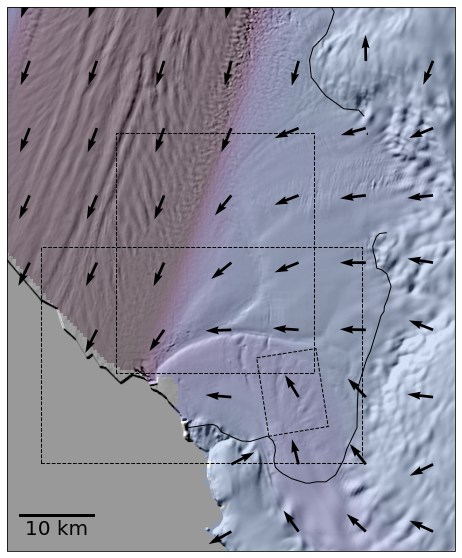

In [13]:
# Load the TIFF file
file_path = '../aaa42c89-41e1-4953-a516-34a90d13e1d3.tiff'  # Update path as needed
with rasterio.open(file_path) as src:
    image_data = src.read(1)  # Reading the first band of the TIFF file
    bounds = src.bounds       # Retrieve the bounds of the TIFF image
    tiff_crs = src.crs        # Retrieve the Coordinate Reference System (CRS)

# Set up Cartopy projection (South Polar Stereographic)
projection = ccrs.SouthPolarStereo(true_scale_latitude=-71, central_longitude=-101)

# Create a figure and axes with the specified projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': projection})

# Plot the TIFF image as the background
img_extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
img = ax.imshow(image_data, origin='upper', extent=img_extent, transform=projection, cmap='gray')

# Add gridlines to the plot (optional)
#gl = ax.gridlines(draw_labels=True, color='lightgrey', linestyle='--', linewidth=0.5)
# gl = ax.gridlines(draw_labels=True,  ylocs=[-75, -74, -73, -72, -71],
#                   color='grey', linestyle='--')

# Normalize velocity vectors to unit length (unit vector)
magnitude[magnitude == 0] = 1  # Avoid division by zero
unit_velx = velx_subset / magnitude
unit_vely = vely_subset / magnitude

# Plot the normalized velocity vectors (unit vectors)
fixed_length = 1.8  # Adjust this to scale the vectors uniformly
skip = 20  # Controls spacing of arrows, increase for more space
quiver = ax.quiver(
    x_b_subset[::skip, ::skip], y_b_subset[::skip, ::skip],  # Position
    unit_velx[::skip, ::skip] * fixed_length, unit_vely[::skip, ::skip] * fixed_length,  # Unit vectors
    transform=projection, color='black', scale=5, scale_units='inches', width=0.006, zorder=4  # Arrow appearance
)

# Optionally, overlay velocity magnitude using pcolormesh
data2 = ax.pcolormesh(x_b_subset, y_b_subset, magnitude, transform=projection, cmap=new_cmap, zorder=1, alpha=0.3)

# Add the grounding line geometry
ax.add_geometries(GL_crs_transformed['geometry'], facecolor='None', crs=projection, edgecolor='k', linewidth=1)

# Set the plot extent to match the TIFF image bounds
ax.set_extent([bounds.left, bounds.right, bounds.bottom, bounds.top], crs=projection)

# Add a scale bar
fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(
    ax.transData, 10000, '10 km', 'lower left',
    pad=0.5, color='k', frameon=False, size_vertical=350, fill_bar=True, sep=3.5, fontproperties=fontprops
)
ax.add_artist(scalebar)

# Add bounding boxes for other figures (e.g., deformation or strain)
ax.add_geometries(smallbbox['geometry'], crs=projection, facecolor='none', edgecolor='k', linestyle='--', linewidth=1, zorder=3)

# Convert coordinates to EPSG:3031 for the bounding boxes
llcrnr_x, llcrnr_y = transformer.transform(llcrnrlon, llcrnrlat)
urcrnr_x, urcrnr_y = transformer.transform(urcrnrlon, urcrnrlat)
llcrnr_x2, llcrnr_y2 = transformer.transform(llcrnrlon2, llcrnrlat2)
urcrnr_x2, urcrnr_y2 = transformer.transform(urcrnrlon2, urcrnrlat2)

# Create and plot the bounding boxes
bbox = box(llcrnr_x, llcrnr_y, urcrnr_x, urcrnr_y)
bbox2 = box(llcrnr_x2, llcrnr_y2, urcrnr_x2, urcrnr_y2)

gdf_bbox = gpd.GeoDataFrame(index=[0], crs="EPSG:3031", geometry=[bbox])
gdf_bbox2 = gpd.GeoDataFrame(index=[0], crs="EPSG:3031", geometry=[bbox2])

ax.add_geometries(gdf_bbox.geometry, crs=projection, facecolor='none', edgecolor='k', linewidth=1, linestyle='--')
ax.add_geometries(gdf_bbox2.geometry, crs=projection, facecolor='none', edgecolor='k', linewidth=1, linestyle='--')

# Set x-limits for zooming in on the region of interest
plt.xlim([-1615000, -1555000])

# Save the figure with high DPI for quality output
#plt.savefig('zoompigvelocity_bbox31oct.png', format='png', dpi=400)

# Show the plot (optional)
#plt.show()

# Extras
## Some small bbox stats

In [14]:
# Ckecking a quick stat: extracting average velocity withing smallbbox

# Get the bounds of the smallbbox
bbox_bounds = smallbbox.total_bounds
x_min, y_min, x_max, y_max = bbox_bounds

# Subset the grid to points within the bounding box bounds
x_mask = (x_b_subset >= x_min) & (x_b_subset <= x_max)
y_mask = (y_b_subset >= y_min) & (y_b_subset <= y_max)
combined_mask = x_mask & y_mask

# --> Reduces the size of the dataset significantly before applying more computationally intensive checks

In [15]:
# Subset velocity data using the combined mask
x_b_filtered = x_b_subset[combined_mask]
y_b_filtered = y_b_subset[combined_mask]
velx_filtered = velx_subset[combined_mask]
vely_filtered = vely_subset[combined_mask]

# Convert filtered grid points to shapely Points for precise masking
from shapely.geometry import Point
filtered_points = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in zip(x_b_filtered, y_b_filtered)],
    crs="EPSG:3031"
)

# Identify points within the exact polygon of the smallbbox
precise_mask = filtered_points.within(smallbbox.geometry.iloc[0])
# --> Accurately filters points to those that are strictly inside the polygon of the smallbbox

# Apply precise mask to further subset velocity data
velx_within_bbox = velx_filtered[precise_mask]
vely_within_bbox = vely_filtered[precise_mask]

# Compute velocity magnitude
velocity_magnitude = np.sqrt(velx_within_bbox**2 + vely_within_bbox**2)

# Calculate average velocity
average_velocity = np.mean(velocity_magnitude)

print(f"Average Velocity in smallbbox: {average_velocity:.2f} m/yr")


Average Velocity in smallbbox: 735.41 m/yr


In [16]:
# Calculate the area of smallbbox in square meters
bbox_area_m2 = smallbbox.geometry.area.iloc[0]

# Convert to square kilometers
bbox_area_km2 = bbox_area_m2 / 1_000_000

print(f"Area of smallbbox: {bbox_area_km2:.2f} km2")

Area of smallbbox: 85.15 km2


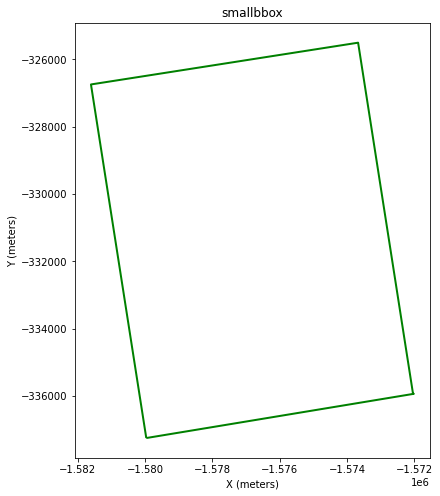

In [17]:
# Quick vis: plot smallbbox
fig, ax = plt.subplots(figsize=(8, 8))
smallbbox.plot(ax=ax, edgecolor='g', facecolor='none', linewidth=2)

# Add labels for context
ax.set_title("smallbbox")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()


## Zoom in on smallbbox

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


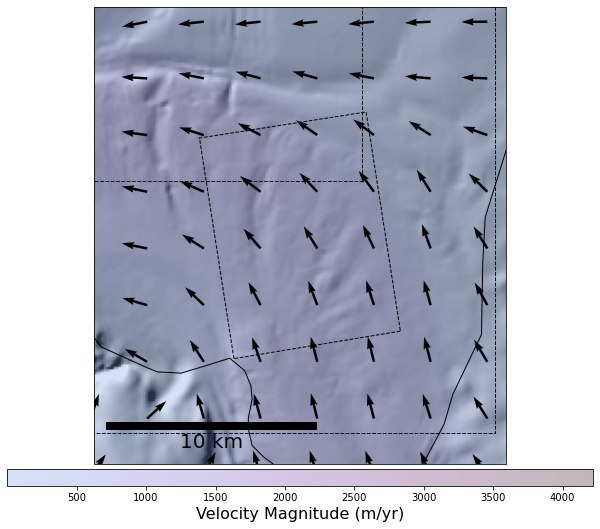

In [18]:
# Load the TIFF file
file_path = '../aaa42c89-41e1-4953-a516-34a90d13e1d3.tiff'  # Update path as needed
with rasterio.open(file_path) as src:
    image_data = src.read(1)  # Reading the first band of the TIFF file
    bounds = src.bounds       # Retrieve the bounds of the TIFF image
    tiff_crs = src.crs        # Retrieve the Coordinate Reference System (CRS)

# Set up Cartopy projection (South Polar Stereographic)
projection = ccrs.SouthPolarStereo(true_scale_latitude=-71, central_longitude=-101)

# Create a figure and axes with the specified projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': projection})

# Plot the TIFF image as the background
img_extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
img = ax.imshow(image_data, origin='upper', extent=img_extent, transform=projection, cmap='gray')

# Add gridlines to the plot (optional)
#gl = ax.gridlines(draw_labels=True, color='lightgrey', linestyle='--', linewidth=0.5)
# gl = ax.gridlines(draw_labels=True,  ylocs=[-75, -74, -73, -72, -71],
#                   color='grey', linestyle='--')

# Normalize velocity vectors to unit length (unit vector)
magnitude[magnitude == 0] = 1  # Avoid division by zero
unit_velx = velx_subset / magnitude
unit_vely = vely_subset / magnitude

# Plot the normalized velocity vectors (unit vectors)
fixed_length = 1.8  # Adjust this to scale the vectors uniformly
skip = 6  # Decrease the skip to plot more arrows
quiver = ax.quiver(
    x_b_subset[::skip, ::skip], y_b_subset[::skip, ::skip],  # Position
    unit_velx[::skip, ::skip] * fixed_length, unit_vely[::skip, ::skip] * fixed_length,  # Unit vectors
    transform=projection, color='black', scale=5, scale_units='inches', width=0.006, zorder=4  # Arrow appearance
)

# Optionally, overlay velocity magnitude using pcolormesh
data2 = ax.pcolormesh(x_b_subset, y_b_subset, magnitude, transform=projection, cmap=new_cmap, zorder=1, alpha=0.3)

# Add the grounding line geometry
ax.add_geometries(GL_crs_transformed['geometry'], facecolor='None', crs=projection, edgecolor='k', linewidth=1)

# Get the bounds of smallbbox for zooming in
bbox_bounds = smallbbox.total_bounds
x_min, y_min, x_max, y_max = bbox_bounds

# Set the plot extent to zoom in on smallbbox
ax.set_extent([x_min, x_max, y_min, y_max], crs=projection)

# Add the bounding box (smallbbox)
ax.add_geometries(smallbbox['geometry'], crs=projection, facecolor='none', edgecolor='k', linestyle='--', linewidth=1, zorder=3)

# Add a scale bar (optional)
fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(
    ax.transData, 10000, '10 km', 'lower left',
    pad=0.5, color='k', frameon=False, size_vertical=350, fill_bar=True, sep=3.5, fontproperties=fontprops
)
ax.add_artist(scalebar)

# Plot the bounding boxes for other features (if needed)
ax.add_geometries(gdf_bbox.geometry, crs=projection, facecolor='none', edgecolor='k', linewidth=1, linestyle='--')
ax.add_geometries(gdf_bbox2.geometry, crs=projection, facecolor='none', edgecolor='k', linewidth=1, linestyle='--')

# Optionally, adjust zoom further
# You can adjust limits to fine-tune zoom level
plt.xlim([x_min - 5000, x_max + 5000])  # Expand a little beyond bbox for context
plt.ylim([y_min - 5000, y_max + 5000])

# Add colorbar (legend) for velocity magnitude using the new_cmap
cbar = plt.colorbar(data2, ax=ax, orientation='horizontal', pad=0.01, aspect=35, shrink=0.70)
cbar.set_label('Velocity Magnitude (m/yr)', fontsize=16)

# Save the figure with high DPI for quality output
# plt.savefig('zoomed_in_velocity_plot.png', format='png', dpi=400)

# Show the plot (optional)
plt.show()
